Here we reproduce the spectraRadius calculation for the lembas model using JAX. (Fig3)

In [1]:
# Avlants
#import numpy
#import scipy.sparse
#from scipy.sparse.linalg import eigs
#from scipy.linalg import eig
#import matplotlib.pyplot as plt
import time
#import pandas

# ours: 
import sys
sys.path.insert(0, '../')
from nn_cno import nn_models
import numpy as np
import scipy as sp
import pandas as pd
import equinox as eqx
import optax
import jax.tree_util as jtu
from jax.experimental import sparse
from jax import numpy as jnp
import jax
import matplotlib.pyplot as plt
import functools as ft



In [2]:

steps = 500

networkSize = 100
density = 0.2
errorSize = 1e-3
noise = 1e-10
initialEig = 1.2
targetEig = 0.95
expFactor = 20

#Generate random test data

network = sp.sparse.random(networkSize, networkSize, density)
sp.sparse.lil_matrix.setdiag(network, 0)
networkList = sp.sparse.find(network)
networkList = np.array((networkList[1], networkList[0])) #we flip the network for rowise ordering

weights = np.random.normal(0, 0.5, len(networkList[0]))
A = sp.sparse.csr_matrix((weights, networkList), shape=(networkSize, networkSize), dtype='float32')
e1, v = sp.sparse.linalg.eigs(A, k=1)
A.data = initialEig * A.data/abs(e1)



aBefore = A.copy()
print(A.todense())
print(weights)

[[ 0.          0.          0.22997452 ...  0.          0.
  -0.01933691]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.2367709 ]
 [ 0.          0.          0.01332536 ...  0.          0.
   0.        ]]
[ 0.44196192 -0.89806216 -0.29604949 ... -0.55758506 -0.02819497
  0.17342797]


In [3]:
A = aBefore.copy()
# in jax we need a dense matrix: 
M = jnp.zeros(A.shape)


weights = jnp.array(A.data)

#weights = torch.autograd.Variable(torch.from_numpy(A.data), requires_grad=True)
scaleFactor = 1/np.exp(expFactor * targetEig)
optimizer = optax.adam(learning_rate=0.001)
# optimizer = torch.optim.Adam([weights], lr=0.001, weight_decay=0)
opt_state = optimizer.init(weights)

In [4]:
@jax.jit
def compute_radius(w,A,ind):
    A = A.at[ind[0],ind[1]].set(w)
    e_val =  jnp.linalg.eigvals(A)
    return jnp.max(jnp.abs(e_val))

@jax.jit
def compute_loss(w,A,ind):
    radius = compute_radius(w,A,ind)
    l = errorSize * scaleFactor * (jnp.exp(expFactor*radius)-1)
    return l, radius

compute_loss_vg = jax.value_and_grad(compute_loss,has_aux=True)

#@ft.partial(jax.jit, static_argnums=1)
@jax.jit
def make_step(params, A, indices, opt_state):
    (loss,radius), grads = compute_loss_vg(params,A, indices)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, radius, params, opt_state


In [5]:
#check compute_radius
compute_radius(weights,M,networkList)

DeviceArray(1.1999978, dtype=float32)

In [6]:
#check compute_loss
compute_loss(weights,M,networkList)

(DeviceArray(0.14840664, dtype=float32), DeviceArray(1.1999978, dtype=float32))

In [7]:
(loss, radius), grads = compute_loss_vg(weights, M, networkList)


In [8]:
#check make_step
loss, radius, params, opt_state = make_step(weights,M, networkList, opt_state)

In [9]:
steps = 500
storeEig = np.zeros(steps)
init_weights = weights.copy()

start = time.time()
for i in range(steps):
    loss, radius, weights, opt_state = make_step(weights,M, networkList, opt_state)
    
    storeEig[i] = radius
    if radius <= targetEig:
        storeEig[i:] = storeEig[i]
        break

    if i % 5 == 0:
        print('i={:.0f}, e={:.4f}, l={:.5f}'.format(i, storeEig[i], loss.item()))


print('Time:',  time.time()-start)

aAfter = A.copy()
aAfter.data = weights

i=0, e=1.2000, l=0.14841
i=5, e=1.1282, l=0.03530
i=10, e=1.1168, l=0.02809
i=15, e=1.0825, l=0.01414
i=20, e=1.0659, l=0.01015
i=25, e=1.0507, l=0.00749
i=30, e=1.0397, l=0.00602
i=35, e=1.0304, l=0.00499
i=40, e=1.0226, l=0.00427
i=45, e=1.0169, l=0.00381
i=50, e=1.0127, l=0.00351
i=55, e=1.0041, l=0.00295
i=60, e=0.9975, l=0.00258
i=65, e=0.9921, l=0.00232
i=70, e=0.9862, l=0.00206
i=75, e=0.9807, l=0.00185
i=80, e=0.9754, l=0.00166
i=85, e=0.9735, l=0.00160
i=90, e=0.9766, l=0.00170
i=95, e=0.9693, l=0.00147
i=100, e=0.9755, l=0.00167
i=105, e=0.9680, l=0.00143
i=110, e=0.9641, l=0.00133
i=115, e=0.9625, l=0.00128
i=120, e=0.9581, l=0.00118
i=125, e=0.9608, l=0.00124
i=130, e=0.9566, l=0.00114
i=135, e=0.9556, l=0.00112
i=140, e=0.9529, l=0.00106
i=145, e=0.9514, l=0.00103
i=150, e=0.9562, l=0.00113
Time: 0.885490894317627


Text(0.5, 0, 'Steps')

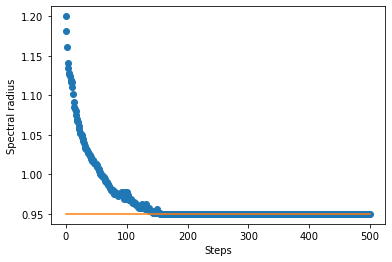

In [10]:
plt.rcParams["figure.figsize"] = (3,3)
plt.plot(range(len(storeEig)), storeEig, 'o')
plt.plot([0, steps], [targetEig, targetEig])
plt.ylabel('Spectral radius')
plt.xlabel('Steps')

<Figure size 432x432 with 0 Axes>

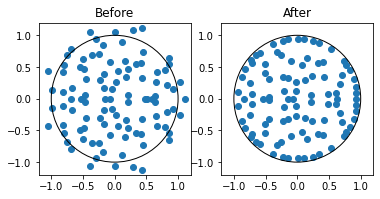

In [13]:

plt.tight_layout()

plt.rcParams["figure.figsize"] = (6,6)
plt.figure()
eBefore = sp.linalg.eig(aBefore.todense(), left = False, right=False)
eAfter = sp.linalg.eig(aAfter.todense(), left = False, right=False)

dfBefore = pd.DataFrame((eBefore.real, eBefore.imag), index=['Real', 'Imaginary']).T
dfAfter = pd.DataFrame((eAfter.real, eAfter.imag), index=['Real', 'Imaginary']).T


axisLim = 1.2
for i in [1, 2]:
    plt.subplot(1,2,i)
    if i == 1:
        plt.scatter(eBefore.real, eBefore.imag)
        plt.title('Before')
    else:
        plt.scatter(eAfter.real, eAfter.imag)
        plt.title('After')


    tmp = plt.Circle((0, 0), 1, color='k', fill=False)
    plt.gca().add_patch(tmp)
    plt.gca().set_aspect('equal', 'box')
    plt.xlim([-axisLim, axisLim])
    plt.ylim([-axisLim, axisLim])

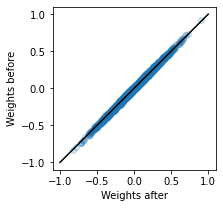

In [15]:
plt.rcParams["figure.figsize"] = (3,3)
plt.figure()
df = pd.DataFrame((aAfter.data, aBefore.data), index=['Before', 'After']).T
plt.plot(aAfter.data, aBefore.data, 'o', alpha=0.2)
plt.xlabel('Weights after')
plt.ylabel('Weights before')
distance = np.sum(np.square(aAfter.data - aBefore.data))
#plt.text(-1, 1, 'SS = {:.3f}'.format(distance))
#plt.plot([-1, 1], [-1, 1], transform=ax2.transAxes)
plt.plot([-1, 1], [-1, 1], 'k-')
#plt.grid(True)
plt.gca().set_aspect('equal', 'box')

Text(0, 0.5, 'Deviation_n+1')

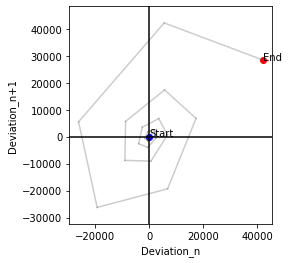

In [17]:
plt.rcParams["figure.figsize"] = (8,4)
plt.figure()
numberOfSteps = 100
amplitude = 0.001
j = 0

resultsBefore = np.zeros((numberOfSteps+1, networkSize))
resultsBefore[0,:] = amplitude * np.random.randn(networkSize)
resultsBefore[0,0] = amplitude

for i in range(numberOfSteps):
    resultsBefore[i+1,:] = aBefore.dot(resultsBefore[i,:])

plt.subplot(1,2,1)

for i in range(numberOfSteps-1):
    plt.plot(resultsBefore[i:(i+2), j], resultsBefore[(i+1):(i+3), j], 'k-', alpha=0.2)

plt.plot(resultsBefore[0, j], resultsBefore[1, j], 'o', color='b')
plt.text(resultsBefore[0, j], resultsBefore[1, j], 'Start')
plt.plot(resultsBefore[-2, j], resultsBefore[-1, j], 'o', color='r')
plt.text(resultsBefore[-2, j], resultsBefore[-1, j], 'End')
plt.gca().set_aspect('equal', 'box')
plt.axis('equal')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('Deviation_n')
plt.ylabel('Deviation_n+1')

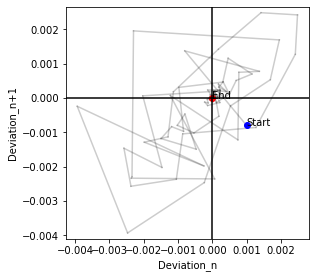

In [18]:
resultsAfter = np.zeros((numberOfSteps+1, networkSize))
resultsAfter[0,:] = resultsBefore[0,:].copy()

for i in range(numberOfSteps):
    resultsAfter[i+1,:] = aAfter.dot(resultsAfter[i,:])

plt.subplot(1,2,2)
colorProperty = ['k', 'b']
for i in range(numberOfSteps-1):
    plt.plot(resultsAfter[i:(i+2), j], resultsAfter[(i+1):(i+3), j], 'k-', alpha=0.2)

plt.plot(resultsAfter[0, j], resultsAfter[1, j], 'o', color='b')
plt.text(resultsAfter[0, j], resultsAfter[1, j], 'Start')
plt.plot(resultsAfter[-2, j], resultsAfter[-1, j], 'o', color='r')
plt.text(resultsAfter[-2, j], resultsAfter[-1, j], 'End')
plt.gca().set_aspect('equal', 'box')
plt.axis('equal')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlabel('Deviation_n')
plt.ylabel('Deviation_n+1')
#plt.plot([0, 0.3], [0, 0.3], 'k-')
plt.tight_layout()

# Everything below this line are tests and failed attempts

In [67]:
# checking if we could compute the gradient
# we have 2 options: 
# 1) compute the gradient using the jax library (jax eig only defined on dense matrices)
# 2) compute the gradient by Avlant's formula

def jax_computeSpectralRadius(spM1):
    e_val =  jnp.linalg.eigvals(spM1.todense())
    return jnp.max(jnp.abs(e_val))

@jax.value_and_grad
def jax_compute_loss(weights,spM):
    spM.data = weights
    spectralRadius = jax_computeSpectralRadius(spM)
    loss = errorSize * scaleFactor * (jnp.exp(expFactor*spectralRadius)-1)
    return(loss)


A = aBefore.copy()
jaxA = jax.experimental.sparse.BCOO.from_scipy_sparse(A)
v,g = jax_compute_loss(weights,jaxA)

In [68]:
print(weights.shape)
print(g.shape)
g

(19,)
(19,)


DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan], dtype=float32)

In [82]:
@jax.value_and_grad
def jax_computeSpectralRadius(w,spM1):
    spM1.data = w
    dM1 = spM1.todense()
    e_val =  jnp.linalg.eigvals(dM1)
    #print(e_val)
    return jnp.max(jnp.abs(e_val))

A = aBefore.copy()
jaxA = jax.experimental.sparse.BCOO.from_scipy_sparse(A)
v = jax_computeSpectralRadius(weights, jaxA)
v

(DeviceArray(1.2000018, dtype=float32),
 DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
              nan, nan, nan, nan, nan, nan, nan], dtype=float32))

In [85]:
class specRadius(eqx.Module):

    weights: jnp.ndarray
    A: sparse.BCOO = eqx.static_field()

    def __init__(self, networkList: list, np_weights: jnp.ndarray, nStates: int):
        super().__init__()
        
        scipyA =  sp.sparse.csr_matrix((weights, networkList), shape=(nStates, nStates))
        self.A = sparse.BCOO.from_scipy_sparse(scipyA)
        self.weights = weights
    
    def set_weights(self, input_weights):
        self = eqx.tree_at(lambda l: l.weights, self, replace=jnp.asarray(input_weights))

    def __call__(self):
        self.A.data = self.weights

        e_val =  jnp.linalg.eigvals(self.A.todense())
        return jnp.max(jnp.abs(e_val))
        

In [86]:
sR = specRadius(networkList, weights, networkSize)

In [94]:
sR.weights

DeviceArray([ 0.14147443,  1.2915525 ,  0.4772732 ,  0.5789341 ,
             -0.3088316 ,  0.56437916, -0.20301604,  0.7478714 ,
             -0.5491153 , -0.6911814 , -1.2119398 , -0.02114597,
             -1.7233162 , -0.68915874, -0.11731061,  0.385021  ,
             -0.853952  , -0.15604219, -0.62800735], dtype=float32)

In [87]:
sR()

DeviceArray(1.2000018, dtype=float32)

In [95]:
@eqx.filter_value_and_grad
def class_compute_loss(specRadModel):
    spectralRadius = specRadModel()
    loss = spectralRadius
    return(loss)


In [96]:
loss, grads = class_compute_loss(sR)

In [97]:
loss

DeviceArray(1.2000018, dtype=float32)

In [98]:
grads.weights

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
             nan, nan, nan, nan, nan, nan, nan], dtype=float32)

`jax.Value_and_grad` works on dense matrix input and `eigvals`:


In [147]:
M = jnp.zeros((3,3))
M = M.at[[0,1,2],[0,1,2]].set([1,2,3])
@jax.value_and_grad
def test_matrix_input(M):
    e_val =  jnp.linalg.eigvals(M)
    return jnp.max(jnp.abs(e_val))
print("M:")
print(M)
v,g = test_matrix_input(M)
print("v:")
print(v)
print("g:")
print(g)

M:
[[1. 0. 0.]
 [0. 2. 0.]
 [0. 0. 3.]]
v:
3.0
g:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


In [156]:
@jax.jit
@jax.value_and_grad
def test_matrix_input(M):
    e_val =  jnp.linalg.eigvals(M)
    return jnp.max(jnp.abs(e_val))

In [157]:
%%timeit
M = jnp.zeros((3,3))
# lets time it. 
M = M.at[[0,1,2],[0,1,2]].set([1,2,3])
v,g = test_matrix_input(M)

# without jitting:
# 8.96 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# with jitting:
# 4.14 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

4.14 ms ± 323 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


`jax.Value_and_grad` works on vector input and then `eigvals`:


In [144]:

M = jnp.zeros((3,3))
@jax.value_and_grad
def test1(w,M):
    M = M.at[[0,1,2],[0,1,2]].set(w)
    e_val =  jnp.linalg.eigvals(M)
    return jnp.max(jnp.abs(e_val))
print("M:")
print(M)
w = jnp.array([1.0,2.0,4.0])
v,g = test1(w,M)
print("v:")
print(v)
print("g:")
print(g)

M:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v:
4.0
g:
[0. 0. 1.]


In [164]:
@jax.jit
@jax.value_and_grad
def test_vector(w,M):
    M = M.at[[0,1,2],[0,1,2]].set(w)
    e_val =  jnp.linalg.eigvals(M)
    return jnp.max(jnp.abs(e_val))

In [166]:
%%timeit
M = jnp.zeros((3,3))
# lets time it. 

w = jnp.array([1.0,2.0,4.0])
v,g = test_vector(w,M)
# without jitting:
# 18.2 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# with jitting:
# 654 µs ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

654 µs ± 5.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Sparse - dense version? 

In [214]:
dM = sp.sparse.csr_matrix(([1,2,3], [[0,1,2],[0,1,2]]), shape=(3, 3), dtype='float32')
M = jax.experimental.sparse.BCOO.from_scipy_sparse(dM)
@jax.value_and_grad
def test_sparse_dense(w,M):
    M.data = w
    e_val =  jnp.linalg.eigvals(M.todense())
    return jnp.max(jnp.abs(e_val))
print("M:")
print(M)
w = jnp.array([1.0,2.0,7.0])
v,g = test_sparse_dense(w,M)
print("v:")
print(v)
print("g:")
print(g)

M:
BCOO(float32[3, 3], nse=3)
v:
7.0
g:
[0. 0. 1.]


Let's check what didnt work yesterday

In [213]:
A_save = A.copy()
A.todense()

matrix([[ 0.        , -0.43581876,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.18418576, -0.19678171,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  2.2863867 ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.6298148 ,  0.        ,  0.        ]],
       dtype=float32)

In [272]:
sp.sparse.csr_matrix(([1.,-0.43,0.18,-0.197,2.286,0.63], [[0,0,1,1,2,4],[0,1,2,3,4,2]]), shape=(5, 5), dtype='float32').todense()

matrix([[ 1.   , -0.43 ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.18 , -0.197,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  2.286],
        [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.63 ,  0.   ,  0.   ]], dtype=float32)

In [311]:
dM = sp.sparse.csr_matrix(([1.,0.,1.,1.,2.,1.], [[2,0,1,1,0,3],[3,1,2,0,3,1]]), shape=(4, 4), dtype='float32')
M = jax.experimental.sparse.BCOO.from_scipy_sparse(dM)

@jax.value_and_grad
def test_sparse_dense(w,M):
    M.data = w
    e_val =  jnp.linalg.eigvals(M.todense())
    return jnp.max(jnp.abs(e_val))

w = jnp.array([1.,1.,0.,0.,1.,1.])
M.data = w
print("Matrix (M):")
print(M.todense())
e_val =  jnp.linalg.eigvals(M.todense())
print(e_val)
v,g = test_sparse_dense(w,M)
print("v:")
print(v)
print("g:")
print(g)

# print("--------------------------")
# w = jnp.array([1.,0.,1.,1.,1.,1.])
# M.data = w
# print("Matrix (M):")
# print(M.todense())
# e_val =  jnp.linalg.eigvals(M.todense())
# print(e_val)
# v,g = test_sparse_dense(w,M)
# print("v:")
# print(v)
# print("g:")
# print(g)

Matrix (M):
[[0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
v:
0.0
g:
[nan nan nan nan nan nan]


In [300]:
M = jnp.zeros((4,4))
@jax.value_and_grad
def test_dense(w,A,ind):
    A = A.at[ind[0],ind[1]].set(w)
    e_val =  jnp.linalg.eigvals(A)
    return jnp.max(jnp.abs(e_val))

indices = np.array([[2,0,1,1,0,3],[3,1,2,0,3,1]])

w = jnp.array([1.,0.,1.,1.,2.,1.])
M = M.at[indices[0],indices[1]].set(w)
print("Matrix (M):")
print(M)
e_val =  jnp.linalg.eigvals(M)
print(e_val)
v,g = test_dense(w,M,indices)
print("v:")
print(v)
print("g:")
print(g)

# print("--------------------------")
# w = jnp.array([0,1.,-1.,1.])
# M.data = w
# print("Matrix (M):")
# print(M.todense())
# e_val =  jnp.linalg.eigvals(M.todense())
# print(e_val)
# v,g = test_sparse_dense(w,M)
# print("v:")
# print(v)
# print("g:")
# print(g)

Matrix (M):
[[0. 0. 0. 2.]
 [1. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
[-7.2112513e-01+1.2490247j -7.2112513e-01-1.2490247j
  1.4422497e+00+0.j         1.6660005e-08+0.j       ]
v:
1.4422497
g:
[1.6024998e-01 1.8087150e-07 1.6025004e-01 3.2049999e-01 1.6024998e-01
 4.8074979e-01]


In [258]:
#print(A.todense())
M = jax.experimental.sparse.BCOO.from_scipy_sparse(A)
weights = jnp.array(A.data)



def test_sparse_dense(w,M):
    M.data = w
    e_val =  jnp.linalg.eigvals(M.todense())
    print(e_val)
    return e_val[0]

test_sparse_dense = jax.value_and_grad(test_sparse_dense,holomorphic=True)

jaxA = jax.experimental.sparse.BCOO.from_scipy_sparse(A)

v,g = test_sparse_dense(jnp.complex64(weights),jaxA)
print(v)
print(g)

Traced<ConcreteArray([ 0. +0.j  0. +0.j  1.2+0.j -1.2+0.j  0. +0.j], dtype=complex64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([ 0. +0.j,  0. +0.j,  1.2+0.j, -1.2+0.j,  0. +0.j], dtype=complex64)
  tangent = Traced<ShapedArray(complex64[5])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(complex64[5]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x14d549200>, in_tracers=(Traced<ConcreteArray([[ 1.0000000e+00+0.j  0.0000000e+00+0.j  0.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j]
 [ 1.0000000e+00+0.j  1.1312915e-30+0.j  0.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j]
 [-4.8850887e-02-0.j  1.3450789e-01-0.j  8.7634075e-01+0.j
  -0.0000000e+00-0.j  4.5994365e-01-0.j]
 [-4.8850879e-02-0.j -1.3450788e-01-0.j  8.7634075e-01+0.j
  -0.0000000e+00-0.j -4.5994356e-01-0.j]
 [ 1.0000000e+00+0.j  1.1312914e-30+0.j  0.0000000e+00+0.j
   0.0000000e+00+0.j  0.0000000e+00+0.j]], dtype=complex64):JaxprTrace(level=1/0)>, Traced<ConcreteArray([[ 1

In [222]:
jnp.linalg.eigvals(A.todense())

DeviceArray([ 0.       +0.j,  0.       +0.j,  1.2      +0.j,
             -1.2000002+0.j,  0.       +0.j], dtype=complex64)

In [232]:
abs(1+2j)

2.23606797749979

In [235]:
np.sqrt(1+4)

2.23606797749979

In [239]:
c= np.array([1+2j,2+1j,2+2j])

In [241]:
abs(c)

array([2.23606798, 2.23606798, 2.82842712])

In [242]:
cr = np.real(c)
cr

array([1., 2., 2.])

In [243]:
ci = np.imag(c)
ci

array([2., 1., 2.])

In [ ]:
# implement the spectralRadius class as a function. 

def spectralRadius(weights, A, networkList):
    A.data = weights

    jax.scipy.linalg.eigh



class spectralRadius(torch.autograd.Function):
    @staticmethod
    def forward(ctx, weights, A, networkList):
        ctx.dim = weights.shape
        ctx.tol = 10**-6
        weights = weights.detach().numpy().flatten()

        ctx.networkList = networkList
        ctx.weights = weights
        ctx.A = A
        ctx.A.data = ctx.weights


        try:
            e, v = eigs(ctx.A, k=1, which='LM', ncv=100, tol=ctx.tol)
            v = v[:,0]
            e = e[0]
        except  (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('Forward fail (did not find any eigenvalue with eigs)')
            tmpA = ctx.A.toarray()
            e, v, w = lreig(tmpA) #fall back to solving full eig problem

        spectralRadius = numpy.abs(e)
        ctx.e = e
        ctx.v = v
        ctx.w = numpy.empty(0)

        return torch.from_numpy(numpy.asarray(spectralRadius))

    @staticmethod
    def backward(ctx, grad_output):
        v = ctx.v
        e = ctx.e
        w = ctx.w
        networkList = ctx.networkList
        tmpA = ctx.A
        tmpA.data = ctx.weights
        tmpA = tmpA.T  #tmpA.T.toarray()

        if w.shape[0]==0:
            try:
                eT = e
                if numpy.isreal(eT): #does for some reason not converge if imag = 0
                    eT = eT.real
                e2, w = eigs(tmpA, k=1, sigma=eT, OPpart='r', tol=ctx.tol)
                selected = 0 #numpy.argmin(numpy.abs(e2-eT))
                w = w[:,selected]
                e2 = e2[selected]
                #Check if same eigenvalue
                if abs(e-e2)>(ctx.tol*10):
                    print('Backward fail (eigs left returned different eigenvalue)')
                    w = numpy.empty(0)
                    #e, v, w = lreig(tmpA) #fall back to solving whole eig problem
            except (KeyboardInterrupt, SystemExit):
                raise
            except:
                print('Backward fail (did not find any eigenvalue with eigs)')
                #e, v, w = lreig(tmpA) #fall back to solving full eig problem
                delta = numpy.zeros(ctx.weights.shape)


        if w.shape[0] != 0:
            divisor = w.T.dot(v).flatten()
            if abs(divisor) == 0:
                delta = numpy.zeros(ctx.weights.shape)
                print('Empty eig')
            else:
                delta = numpy.multiply(w[networkList[0]], v[networkList[1]])/divisor
                direction = e/numpy.abs(e)
                delta = (delta/direction).real
        else:
            #print('Empty eig')
            delta = numpy.zeros(ctx.weights.shape)

        #deltaFilter = numpy.not_equal(numpy.sign(delta), numpy.sign(ctx.weights))
        #delta[deltaFilter] = 0

        delta = torch.tensor(delta, dtype = grad_output.dtype)

        constrainNorm = True
        if constrainNorm:
            norm = torch.norm(delta, 2)
            if norm>10:
                delta = delta/norm #typical seems to be ~0.36
            #delta = delta * numpy.abs(ctx.weights)
            #delta = delta/norm(delta)


        dW = grad_output * delta

        return dW, None, None, None



In [ ]:

for i in range(steps):
    optimizer.zero_grad()
    A.data = weights.detach().numpy()
    spectralRadius = bionetwork.spectralRadius.apply(weights, A, networkList)
    storeEig[i] = abs(spectralRadius.item())

    if spectralRadius.item()>targetEig:
        loss = errorSize * scaleFactor * (torch.exp(expFactor*spectralRadius)-1)
        #loss = errorSize * torch.abs(spectralRadius)
        #loss = errorSize * torch.square(spectralRadius)
    else:
        storeEig[i:] =storeEig[i]
        break
    loss.backward()
    optimizer.step()
    weights.data = weights.data + torch.randn(weights.shape) * noise

    if i % 5 == 0:
        print('i={:.0f}, e={:.4f}, l={:.5f}'.format(i, storeEig[i], loss.item()))

e = bionetwork.spectralRadius.apply(weights, A, networkList)

print('Time:',  time.time()-start)

aAfter = A.copy()
aAfter.data = weights.detach().numpy()

## Test automatic differentiation on eigs

It seems to work only on some matrices

## Test `eig` computations

At this point it is not clear how to compute the eigenvalues of the matrix with jax:D 


In [ ]:

# dense --------------------
# diagonal matrix: 
dA_diag = np.diag([1.,2.,3.,4.,5.])
# print(A_diag)

# symmetric matrix
A_sym = np.random.rand(5,5)
dA_sym = A_sym.T @ A_sym
# print(A_sym)

# assymetric matrix: 
dA_asym = np.random.rand(5,5)
# print(A_asym)

# sparse ------------------
# diagonal matrix: 
sA_diag = sp.sparse.csr_matrix(dA_diag)

# symmetric matrix
sA_sym = sp.sparse.csr_matrix(dA_sym)

# assymetric matrix: 
sA_asym = sp.sparse.csr_matrix(dA_asym)

In [ ]:
# test dense eigenvalue solver.

e_val, e_vec = sp.linalg.eig(dA_diag)
print("dense diagonal eig: {}".format(e_val))

e_val, e_vec = sp.linalg.eig(dA_sym)
print("dense symmetric eig: {}".format(e_val))

e_val, e_vec = sp.linalg.eig(dA_asym)
print("dense asymmetric eig: {}".format(e_val))

dense diagonal eig: [1.+0.j 2.+0.j 3.+0.j 4.+0.j 5.+0.j]
dense symmetric eig: [8.06603349+0.j 0.01739985+0.j 0.08720788+0.j 1.09022592+0.j
 1.14549474+0.j]
dense asymmetric eig: [ 2.70793357+0.j  0.53293532+0.j  0.31176538+0.j -0.49553591+0.j
 -0.30791125+0.j]


In [ ]:
# test dense eigenvalue solver.

e_val, e_vec = sp.linalg.eigh(dA_diag)
print("dense diagonal eig: {}".format(e_val))

e_val, e_vec = sp.linalg.eigh(dA_sym)
print("dense symmetric eig: {}".format(e_val))

# eigh is wrong for assymetric matrices -> there is no error raised!
e_val, e_vec = sp.linalg.eigh(dA_asym)
print("dense asymmetric eig (wrong): {}".format(e_val))


dense diagonal eig: [1. 2. 3. 4. 5.]
dense symmetric eig: [0.01739985 0.08720788 1.09022592 1.14549474 8.06603349]
dense asymmetric eig (wrong): [-0.39055537 -0.27205606  0.05384859  0.43511236  2.92283759]


In [ ]:
# test sparse eigenvalue solver.

e_val, e_vec = sp.sparse.linalg.eigs(sA_diag, k=1, which='LM', ncv=100, tol=10**-6)
print("sparse diagonal eig: {}".format(e_val))

e_val, e_vec = sp.sparse.linalg.eigs(sA_sym, k=1, which='LM', ncv=100, tol=10**-6)
print("sparse symmetric eig: {}".format(e_val))

e_val, e_vec = sp.sparse.linalg.eigs(sA_asym, k=1, which='LM', ncv=100, tol=10**-6)
print("sparse asymmetric eig: {}".format(e_val))

sparse diagonal eig: [5.+0.j]
sparse symmetric eig: [8.06603349+0.j]
sparse asymmetric eig: [2.70793357+0.j]


In [ ]:
# test jax/lax dense eigenvalue solver.

e_val = jax.lax.linalg.eig(jnp.array(dA_diag),compute_left_eigenvectors=False, compute_right_eigenvectors = False)
print("dense Jax/lax diagonal eig: {}".format(e_val))

e_val =  jax.lax.linalg.eig(jnp.array(dA_sym),compute_left_eigenvectors=False, compute_right_eigenvectors = False)
print("dense Jax/lax  symmetric eig: {}".format(e_val))

e_val =  jax.lax.linalg.eig(jnp.array(dA_asym),compute_left_eigenvectors=False, compute_right_eigenvectors = False)
print("dense Jax/lax  asymmetric eig: {}".format(e_val))



dense Jax/lax diagonal eig: [DeviceArray([1.+0.j, 2.+0.j, 3.+0.j, 4.+0.j, 5.+0.j], dtype=complex64)]
dense Jax/lax  symmetric eig: [DeviceArray([8.066034  +0.j, 0.01739965+0.j, 0.08720782+0.j,
             1.0902258 +0.j, 1.1454947 +0.j], dtype=complex64)]
dense Jax/lax  asymmetric eig: [DeviceArray([ 2.7079346 +0.j,  0.53293526+0.j,  0.31176546+0.j,
             -0.49553594+0.j, -0.30791125+0.j], dtype=complex64)]


In [ ]:
# test jax/numpy dense eigenvalue solver.

e_val = jnp.linalg.eigvals(jnp.array(dA_diag))
print("dense jnp diagonal eig: {}".format(e_val))

e_val =  jnp.linalg.eigvals(jnp.array(dA_sym))
print("dense jnp  symmetric eig: {}".format(e_val))

e_val =  jnp.linalg.eigvals(jnp.array(dA_asym))
print("dense jnp asymmetric eig: {}".format(e_val))

dense jnp diagonal eig: [1.+0.j 2.+0.j 3.+0.j 4.+0.j 5.+0.j]
dense jnp  symmetric eig: [8.066034  +0.j 0.01739965+0.j 0.08720782+0.j 1.0902258 +0.j
 1.1454947 +0.j]
dense jnp asymmetric eig: [ 2.7079346 +0.j  0.53293526+0.j  0.31176546+0.j -0.49553594+0.j
 -0.30791125+0.j]
